<a href="https://colab.research.google.com/github/pgordin/OptDisc2025/blob/main/Graphs8a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Graphs & Social Networks &mdash; lab material
This notebook contains a definition of a python class *Graph*, containing functions described during labs.

Package import.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
from queue import PriorityQueue, deque

## Simple functions from the first classes
This is left just as an example (to compare the behaviour).

In [2]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

## Class *Graph*

In [3]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self, directed = 0):
      """
      Plots the graph using methods from networkx package.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()


    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v):
        """
        Print vertices of a tree in preorder, starting from vertex v.
        """
        order = []

        def DFS(u, parent=None):
            order.append(u)
            for w in sorted(self.graph.get(u, [])):
                if w != parent:
                    DFS(w, u)

        DFS(v)
        return " ".join(map(str, order))


    def postorder(self, v):
        """
        Print vertices of a tree in postorder, starting from vertex v.
        """
        visited = set()
        order = []

        def DFS(u):
            visited.add(u)
            for w in sorted(self.graph.get(u, [])):
                if w not in visited:
                    DFS(w)
            order.append(u)

        DFS(v)
        return " ".join(map(str, order))


    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by a set of vertices V.
        """
        sub_dict = {v: [w for w in self.graph[v] if w in V] for v in V}
        subgraph = Graph.from_dict(sub_dict)
        return subgraph

    def ConnectedComponentsGraphs(self):
        """
        Returns a list of Graph objects, each corresponding to one connected component.
        """
        VT = self.connected_components()
        components = []

        for i, vertex_set in enumerate(VT[1:], start=1):
            sub_dict = {
                v: self.graph[v]
                for v in vertex_set
            }
            subgraph = Graph.from_dict(sub_dict)
            components.append(subgraph)

            #print(f"Connected Component {i}:")
            #print(subgraph)

        return components

    def distance(self, v):
      """
      Computes the distance from vertex v to each vertex reachable from it.
      It uses a BFS approach.
      Result is given as a dictionary of distances.
      """
      dist = {v: 0}   # starting point of a dictionary
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    def ConnectedComponentsBFS(self):
        """
        Finds connected components using BFS (non-recursive).
        Returns a list of Graph objects, each corresponding to one connected component.

        self.graph si a dictionary representing a graph
        goal is to split the graph into connected components
        """
        visited = set()
        components = []  #here we store the connected components

        for vertex in self.graph:
            if vertex not in visited: #if a vertex is not visited is because it belongs to a NEW COMPONENT
                component_vertices = set()
                queue = deque([vertex]) #we use queue (FIFO) to explore nodes ---> THIS ENSURES BFS
                visited.add(vertex)
                component_vertices.add(vertex)
                #we create a queue of all the vertex

                #for each vertex we see if the neighbours are visited, we add them to the current component and to the queue for its future neighbours
                while queue:
                    current = queue.popleft()
                    for neighbor in self.graph[current]:
                        if neighbor not in visited:
                            visited.add(neighbor)
                            component_vertices.add(neighbor)
                            queue.append(neighbor)
                      #we ensure that bfs explores every vertex reachable from the initial v

                # after we have visited everything (queue empty) we build subgraph for this component
                sub_dict = {v: [w for w in self.graph[v] if w in component_vertices]
                          for v in component_vertices}
                components.append(Graph.from_dict(sub_dict)) #we add ecah component to the list of components
        return components

    def ConnectedComponentsDFS_without_recursive(self):
        """
        Finds connected components using DFS (non-recursive).
        Returns a list of Graph objects, each corresponding to one connected component.
        """
        visited = set()
        components = []  #here we store the connected components

        for vertex in self.graph:
            if vertex not in visited: #if a vertex is not visited is because it belongs to a NEW COMPONENT
                component_vertices = set()
                stack = [vertex] #instead of queue we use stack (LIFO) to explore nodes ---> THIS ENSURES DFS

                #for each vertex we see if the neighbours are visited, we add them to the current component and to the stack for its future neighbours
                while stack:
                    current = stack.pop()  # DFS uses LIFO
                    if current not in visited:
                        visited.add(current)
                        component_vertices.add(current)
                        for neighbor in self.graph[current]:
                            if neighbor not in visited:
                                stack.append(neighbor)

                # Create subgraph for this component
                sub_dict = {v: [w for w in self.graph[v] if w in component_vertices]
                            for v in component_vertices}
                components.append(Graph.from_dict(sub_dict))

        return components


    def FloydWarshall(self):
        """
        Computes shortest paths between all pairs of vertices using Floyd-Warshall algorithm.
        Returns a distance matrix and a dictionary mapping vertices to indices.
        """
        vertices = list(self.graph.keys())
        n = len(vertices)

        vertex_to_index = {v: i for i, v in enumerate(vertices)} # Create vertex to index mapping

        dist = np.full((n, n), np.inf) # Initialize distance matrix with infinity
        for i in range(n): # Distance from vertex to itself is 0
            dist[i][i] = 0
        # now, for existing edges:
        for u, neighbors in self.graph.items():
            i = vertex_to_index[u]
            for v in neighbors:
                j = vertex_to_index[v]
                dist[i][j] = 1  # Unweighted graph, we say distance is always 1 for each edge

        # Floyd-Warshall algorithm: update shortest paths using intermediate vertices
        # after the loop, it contains the shortest distance between every pair of v
        # because if the current distance is longer than the new calculated, it changes
        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j] #new distance becomes the current calculated

        return dist, vertex_to_index

    def TopologicalSort(self):
        """
        Returns a list of vertices in topological order:
        it orders vertices so that every edge goes from a vertex earlier in the order to a vertex later in the order.
        Kahn's algorithm
        """
        in_degree = {v: 0 for v in self.graph} #computes numer of edges coming into a vertex
        for u in self.graph:
            for v in self.graph[u]:
                in_degree[v] += 1

        # starts a queue with in-degree 0 vertices -- they are the first in the topological order
        queue = deque([v for v in self.graph if in_degree[v] == 0])
        topo_order = []

        while queue: #process v in order
            u = queue.popleft()
            topo_order.append(u)

            for v in self.graph[u]:  #for every v that points u we decrease indegree of v and when its 0 we add it to the queue (that stores the topo_order)
                in_degree[v] -= 1
                if in_degree[v] == 0:
                    queue.append(v)

        if len(topo_order) != len(self.graph):  #in case v remain unprocessed is beacuse graph has a cycle --- not possibnle
            raise ValueError("Graph contains cycles, topological sort not possible")

        return topo_order


    def GeneralisedDFS(self):
      """
      DFS with a timer.
      """
      global timer

      def DFS(v):
        """
        Internal DFS
        """
        global timer
        visited[v] = timer
        for u in self.graph[v]:
          if u not in visited:
            timer += 1
            DFS(u)
        processed[v] = timer

      timer = 0
      visited = {}
      processed = {}
      for v in self.graph:
        if v not in visited:
          DFS(v)
      return visited, processed

    def TopologicalSort2(self):
      """
      Returns a list of vertices in topological order:
      Lecture version, without checking acyclicity
      """
      ordering = {}
      vis, pro = self.GeneralisedDFS()
      for v in self.graph:
        ordering[v] = pro[v]*len(self.graph) - vis[v]
      order = sorted(ordering, key=ordering.get, reverse=True)

      return ordering, order


## Class *WeightedGraph*

In [31]:
class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # redefinition of printing
    def __str__(self):
        res = super().__str__()
        res += "------------------------\n"
        for v in self.graph:
          res += f"{v}: "
          for u in self.graph[v]:
            res += f"{u}({self.weights[(v, u)]}) "
          res += "\n"
        return res

    # graph plotting
    def plot(self, directed = 0):
      """
      Plots the graph.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      nx.set_edge_attributes(G, self.weights, 'weight')
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')
      labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
      plt.show()


    # Modyfying graphs
    def del_vertex(self, vertex):
      """
      Removes a vertex from the graph
      """
      # TODO - should be done in a different way
      super().del_vertex(vertex)


    def add_arc(self, arc, weight = 1):
      """
      Given pair of vertices (arc variable) add an arc to the graph
      We consider simple, directed graphs.
      """
      super().add_arc(arc)
      u, v = arc
      self.weights[(u, v)] = weight

    def add_edge(self, edge, weight = 1):
      """
      Given pair of vertices (edge variable) add an edge to the graph
      We consider simple, undirected graphs as symmetric digraphs without loops.
      """
      super().add_edge(edge)
      u, v = edge
      self.weights[(u, v)] = weight
      self.weights[(v, u)] = weight

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        When we have at leasdt 3 words we assume that the third one is an edge weight (of type int)
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = WeightedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # two words, the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
          elif len(words) >= 3:             # at least three words, first two are the edge description the third is a weight
            if directed:
              graph.add_arc([words[0], words[1]], int(words[2]))
            else:
              graph.add_edge([words[0], words[1]], int(words[2]))
        file.close()
        return graph

    def min_spanning_tree(self):
      """
      Computes a minimum spanning tree of a graph. Jarnik - Prim algorithm.
      """
      for v in self.graph:  # Choose any vertex of a graph
        break
      wtree = WeightedGraph()
      wtree.add_vertex(v)
      totalweight = 0       # total weight of a tree
      q = PriorityQueue()
      for u in self.graph[v]:
        q.put((self.weights[(v, u)], v, u))
      while not q.empty():
        weight, u, w = q.get()
        if w not in wtree.graph:
          wtree.add_edge([u, w], weight)
          totalweight += weight
          for x in self.graph[w]:
            if x not in wtree.graph:
              q.put((self.weights[(w, x)], w, x))
      if len(wtree.graph) != len(self.graph):
        print("Graph is not connected! Returned is a tree for some connected component.")
      return wtree, totalweight

    def Dijkstra(self, s):
      """
      Computes shortest paths from vertex s to all other vertices.
      Dijkstra's algorithm.
      """
      # Init
      dist = {}
      pred = {}
      for v in self.graph:
        dist[v] = np.inf
        pred[v] = None
      dist[s] = 0
      q = PriorityQueue()
      q.put((0, s))
      while not q.empty():
        d, u = q.get()
        for v in self.graph[u]:  # relaxation
          if dist[v] > dist[u] + self.weights[(u, v)]:
            dist[v] = dist[u] + self.weights[(u, v)]
            pred[v] = u
            q.put((dist[v], v))
      return dist, pred

    def network_flow(self):
      """
      Returns the network flow (a graph with backward arcs) computed from original digraph.
      """
      network = WeightedGraph()
      for v in self.graph:
        for u in self.graph[v]:
          network.add_edge([v, u], 0)
      for v in self.graph:
        for u in self.graph[v]:
          network.weights[(v, u)] = self.weights[(v, u)]
      return network

    def MaxFlow_EK(self, s, t):
      """
      Computes maximum flow from vertex s to vertex t.
      Edmonds-Karp algorithm.
      Flow is returned as a dictionary (of arc weights).
      """
      network = self.network_flow()
      flow = {xx: 0 for xx in network.weights}
      # compute the augfmenting paths
      while True:
        pred = {s: None}    # dict of predecessors
        cap = {s: np.inf}   # dict of capacities
        queue = [s]
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (v not in pred) and network.weights[(u, v)] - flow[(u, v)] > 0:
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
        if t in pred:
          # process the augmenting path
          v = t
          c = cap[t]
          while v != s:
            u = pred[v]
            flow[(u, v)] += c
            flow[(v, u)] -= c
            v = u
        else:
          break       # no augmenting path
      return flow



In [46]:
def positive_flow(flow):
  """
  Having flow (as dictionary) compute the positive flow (as dictionary).
  """
  pos_flow = {}
  for (u, v) in flow:
    if flow[(u, v)] > 0:
      pos_flow[(u, v)] = flow[(u, v)]
  return pos_flow

## Use of code

## Part 8
### Plotting directed graphs.


A: A B C
B: A D
C: B D
D:
------------------------
A: A(2) B(3) C(4) 
B: A(1) D(2) 
C: B(-2) D(3) 
D: 



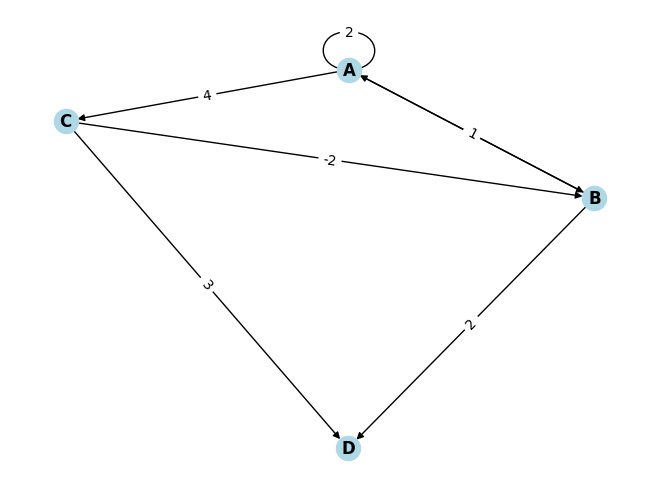

In [22]:
# example 1: weighted graph with a negative edge but no negative cycle

graph_bf1 = {  # adjacency list for a directed graph
    'A': ['A', 'B', 'C'],
    'B': ['A', 'D'],
    'C': ['B', 'D'],
    'D': []
}

weights_bf1 = {
    ('A', 'A'): 2,
    ('A', 'B'): 3,
    ('B', 'A'): 1,
    ('A', 'C'): 4,
    ('C', 'B'): -2,
    ('B', 'D'): 2,
    ('C', 'D'): 3
}

wgraph_bf1 = WeightedGraph(graph_bf1, weights_bf1)
print(wgraph_bf1)
wgraph_bf1.plot(1)

### Max flow

In [26]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted1.txt
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted2.txt

--2025-12-04 14:26:33--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted1.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted1.txt [following]
--2025-12-04 14:26:33--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922 [text/plain]
Saving to: ‘weighted1.txt.1’

weighted1.txt.1     100%[===================>]     922  --.-KB/s    in 0s      

2025-12-04 14:26:33 (45.2 MB/s) - ‘weighted1.txt.1’ saved [922/922]

--2025-12-04 14:26:33--  https://github.com/pgordin/GraphsSN2025/raw/m

In [38]:
!wget https://github.com/pgordin/GraphsSN2025/raw/refs/heads/main/MaxFlow.zip

--2025-12-04 14:38:01--  https://github.com/pgordin/GraphsSN2025/raw/refs/heads/main/MaxFlow.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/MaxFlow.zip [following]
--2025-12-04 14:38:01--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/MaxFlow.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3867 (3.8K) [application/zip]
Saving to: ‘MaxFlow.zip’

MaxFlow.zip         100%[===================>]   3.78K  --.-KB/s    in 0s      

2025-12-04 14:38:01 (40.6 MB/s) - ‘MaxFlow.zip’ saved [3867/3867]



In [39]:
!unzip MaxFlow.zip

Archive:  MaxFlow.zip
  inflating: 15w5a.txt               
  inflating: 20w5b.txt               
  inflating: bad10b.txt              
  inflating: bad100b.txt             
  inflating: bad100c.txt             
  inflating: flow1.txt               


In [32]:
wgraph = WeightedGraph.from_edges("weighted1.txt")
print(wgraph)

1: 5 6 8 14 15 20 22
5: 1 4 7 10 11 14 16 19 22 23 13
6: 1 8 10 12 13
8: 1 2 3 4 6 11 19
14: 1 5 7 10 15 21 24 25 17 18
15: 1 11 14 10 16 18 21 23 25 19
20: 1 11 13 18 23 24
22: 1 2 3 5 12 13 16 9 18
2: 8 12 17 18 19 22
12: 2 4 6 11 22
17: 2 3 14 21 23 25
18: 2 4 15 14 20 22
19: 2 3 4 5 11 16 8 15 23 24 25
3: 8 13 17 19 21 22
13: 3 4 5 6 10 20 22 24
21: 3 14 15 17 23 24
4: 5 8 10 12 13 16 18 19 9
10: 4 5 6 9 14 24 25 13 15
16: 4 5 15 9 19 22 23
7: 5 14
11: 5 8 15 19 20 12
23: 5 15 16 17 19 20 21
9: 4 10 16 22
24: 10 13 14 19 20 21
25: 10 14 15 17 19
------------------------
1: 5(350) 6(300) 8(200) 14(400) 15(100) 20(400) 22(200) 
5: 1(350) 4(300) 7(300) 10(300) 11(400) 14(150) 16(300) 19(100) 22(400) 23(200) 13(200) 
6: 1(300) 8(400) 10(400) 12(350) 13(250) 
8: 1(200) 2(400) 3(200) 4(400) 6(400) 11(100) 19(50) 
14: 1(400) 5(150) 7(100) 10(100) 15(100) 21(250) 24(300) 25(200) 17(400) 18(450) 
15: 1(100) 11(400) 14(100) 10(100) 16(400) 18(200) 21(300) 23(100) 25(400) 19(400) 
20: 1(400) 

In [33]:
flow = wgraph.MaxFlow_EK("1", "25")
print(flow)

{('1', '5'): 350, ('5', '1'): -350, ('1', '6'): 100, ('6', '1'): -100, ('1', '8'): 200, ('8', '1'): -200, ('1', '14'): 400, ('14', '1'): -400, ('1', '15'): 100, ('15', '1'): -100, ('1', '20'): 400, ('20', '1'): -400, ('1', '22'): 50, ('22', '1'): -50, ('5', '4'): 0, ('4', '5'): 0, ('5', '7'): 0, ('7', '5'): 0, ('5', '10'): 300, ('10', '5'): -300, ('5', '11'): 0, ('11', '5'): 0, ('5', '14'): 0, ('14', '5'): 0, ('5', '16'): 0, ('16', '5'): 0, ('5', '19'): 100, ('19', '5'): -100, ('5', '22'): -50, ('22', '5'): 50, ('5', '23'): 0, ('23', '5'): 0, ('5', '13'): 0, ('13', '5'): 0, ('6', '8'): 0, ('8', '6'): 0, ('6', '10'): 100, ('10', '6'): -100, ('6', '12'): 0, ('12', '6'): 0, ('6', '13'): 0, ('13', '6'): 0, ('8', '2'): 150, ('2', '8'): -150, ('8', '3'): 0, ('3', '8'): 0, ('8', '4'): 0, ('4', '8'): 0, ('8', '11'): 0, ('11', '8'): 0, ('8', '19'): 50, ('19', '8'): -50, ('14', '7'): 0, ('7', '14'): 0, ('14', '10'): 0, ('10', '14'): 0, ('14', '15'): 100, ('15', '14'): -100, ('14', '21'): 0, ('21

In [34]:
print(sum(flow[(x, y)] for (x,y) in flow if y == '25'))

1600


s: a b
a: b c d
b: c
c: a d t
d: t
t:
------------------------
s: a(6) b(4) 
a: b(5) c(2) d(3) 
b: c(6) 
c: a(2) d(3) t(4) 
d: t(6) 
t: 



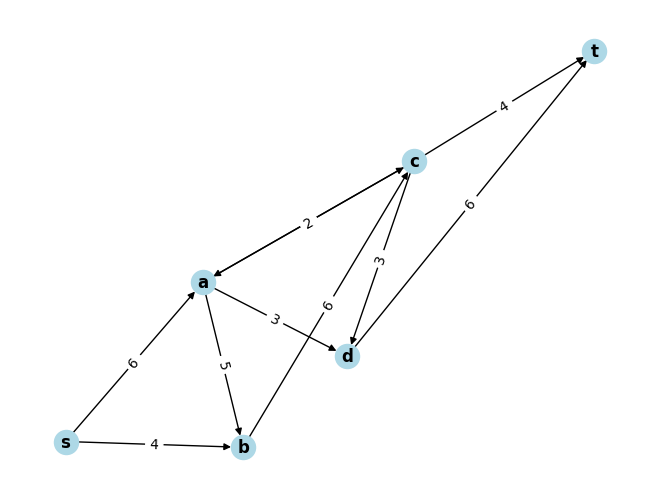

In [51]:
wgraph2 = WeightedGraph.from_edges("flow1.txt", directed=1)
print(wgraph2)
wgraph2.plot(1)

In [52]:
flow2 = wgraph2.MaxFlow_EK("s", "t")
print(flow2)

{('s', 'a'): 6, ('a', 's'): -6, ('s', 'b'): 4, ('b', 's'): -4, ('a', 'b'): 1, ('b', 'a'): -1, ('a', 'c'): 2, ('c', 'a'): -2, ('a', 'd'): 3, ('d', 'a'): -3, ('b', 'c'): 5, ('c', 'b'): -5, ('c', 'd'): 3, ('d', 'c'): -3, ('c', 't'): 4, ('t', 'c'): -4, ('d', 't'): 6, ('t', 'd'): -6}


In [53]:
print(sum(flow2[(x, y)] for (x,y) in flow2 if y == 't'))

10


In [54]:
print(positive_flow(flow2))

{('s', 'a'): 6, ('s', 'b'): 4, ('a', 'b'): 1, ('a', 'c'): 2, ('a', 'd'): 3, ('b', 'c'): 5, ('c', 'd'): 3, ('c', 't'): 4, ('d', 't'): 6}


s: a b
a: b c d
b: c
c: a d t
d: t
t:
------------------------
s: a(6) b(4) 
a: b(1) c(2) d(3) 
b: c(5) 
c: a(0) d(3) t(4) 
d: t(6) 
t: 



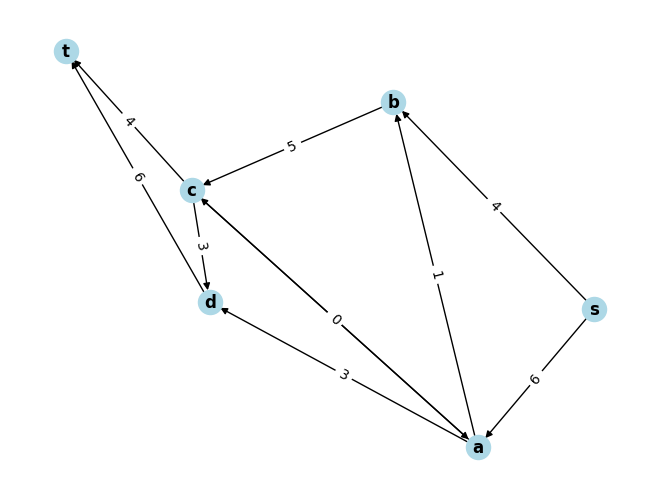

In [58]:
flownet = deepcopy(wgraph2)
flownet.weights = {xx: 0 for xx in flownet.weights}
positive = positive_flow(flow2)
for xx in positive:
  flownet.weights[xx] = positive[xx]
print(flownet)
flownet.plot(1)

## Part 7

### Homework 4 Topological sorting

a: b c
b: d
c: e
d: c
e: d



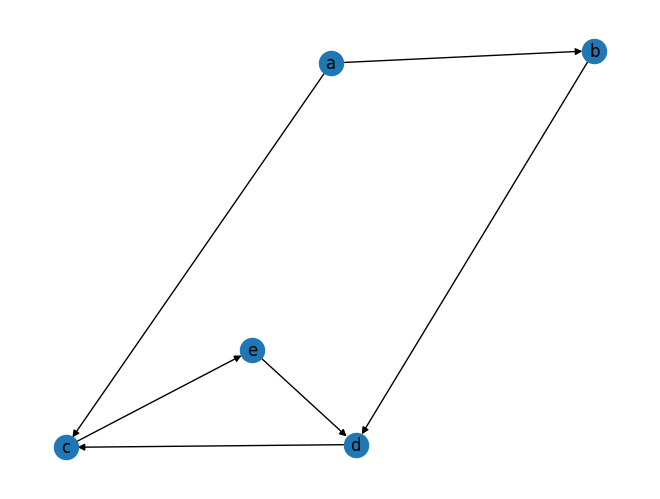

In [7]:
graph_d = {
    'a': ['b', 'c'],
    'b': ['d'],
    'c': ['e'],
    'd': ['c'],
    'e': ['d']
}
graph = Graph(graph_d)
print(graph)
graph.plot(1)

In [ ]:
print(graph.TopologicalSort())

ValueError: Graph contains cycles, topological sort not possible

In [ ]:
vis, pro = graph.GeneralisedDFS()
print(vis)
print(pro)

{'a': 0, 'b': 1, 'd': 2, 'c': 3, 'e': 4}
{'e': 4, 'c': 4, 'd': 4, 'b': 4, 'a': 4}


In [ ]:
ord = graph.TopologicalSort2()
print(ord)

({'a': 20, 'b': 19, 'c': 17, 'd': 18, 'e': 16}, ['a', 'b', 'd', 'c', 'e'])


In [ ]:
graph_d = {
    'a': ['b', 'c'],
    'b': ['d'],
    'c': ['d','e'],
    'd': [],
    'e': ['d']
}
graph = Graph(graph_d)
print(graph)

a: b c
b: d
c: d e
d:
e: d



In [ ]:
print(graph.TopologicalSort())

['a', 'b', 'c', 'e', 'd']


In [ ]:
ordering, order = graph.TopologicalSort2()
print(ordering)
print(order)

{'a': 20, 'b': 9, 'c': 17, 'd': 8, 'e': 16}
['a', 'c', 'e', 'b', 'd']


### Dijkstra's algorithm

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-20 14:43:39--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-20 14:43:39--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt.1’

weighted0.txt.1     100%[===================>]     114  --.-KB/s    in 0s      

2025-11-20 14:43:39 (2.25 MB/s) - ‘weighted0.txt.1’ saved [114/114]



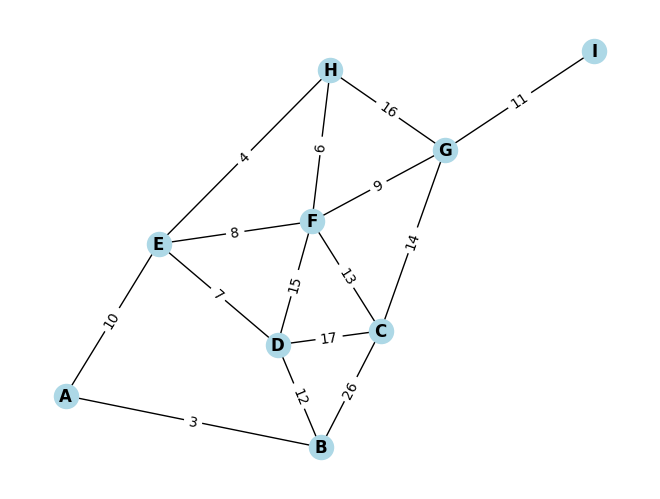

In [ ]:
wgraph = WeightedGraph.from_edges("weighted0.txt")
wgraph.plot()

In [ ]:
dist, pred = wgraph.Dijkstra("A")
print(dist)
print(pred)

{'A': 0, 'B': 3, 'E': 10, 'C': 29, 'D': 15, 'F': 18, 'G': 27, 'H': 14, 'I': 38}
{'A': None, 'B': 'A', 'E': 'A', 'C': 'B', 'D': 'B', 'F': 'E', 'G': 'F', 'H': 'E', 'I': 'G'}


## Part 6 Weighted graphs

In [ ]:
graph = {
    'a': ['b', 'c', 'd'],
    'b': ['a', 'd'],
    'c': ['a'],
    'd': ['a', 'b']
}

weights = {
  ('a', 'b'): 5,
  ('a', 'c'): 7,
  ('a', 'd'): 6,
  ('b', 'a'): 5,
  ('b', 'd'): 1,
  ('c', 'a'): 7,
  ('d', 'a'): 6,
  ('d', 'b'): 1
}

wgraph1 = WeightedGraph(graph, weights)
print(wgraph1)

a: b c d
b: a d
c: a
d: a b
------------------------
a: b(5) c(7) d(6) 
b: a(5) d(1) 
c: a(7) 
d: a(6) b(1) 



In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-13 14:22:12--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-13 14:22:12--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-11-13 14:22:12 (2.09 MB/s) - ‘weighted0.txt’ saved [114/114]



In [ ]:
wgraph2 = WeightedGraph.from_edges("weighted0.txt")
print(wgraph2)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G
------------------------
A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 



A: B E
B: A
E: A H D
H: E F
F: H G C
D: E
G: F I
I: G
C: F
------------------------
A: B(3) E(10) 
B: A(3) 
E: A(10) H(4) D(7) 
H: E(4) F(6) 
F: H(6) G(9) C(13) 
D: E(7) 
G: F(9) I(11) 
I: G(11) 
C: F(13) 

63


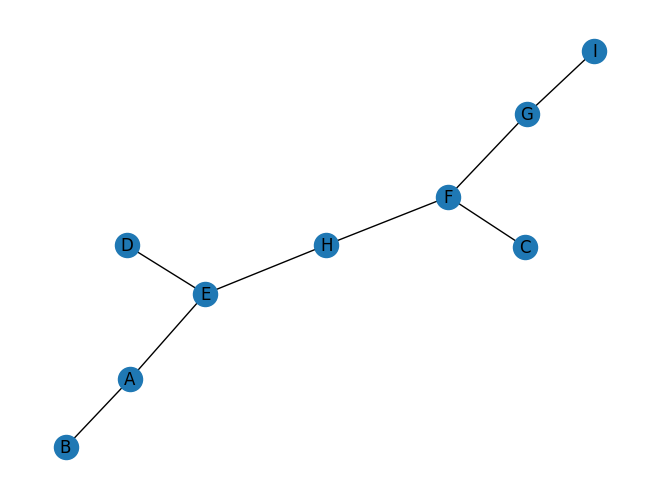

In [ ]:
wtree, totalweight = wgraph2.min_spanning_tree()
print(wtree)
print(totalweight)
wtree.plot()

In [ ]:
wgraph2.add_edge(["a", "b"], 2)
print(wgraph2)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G
a: b
b: a
------------------------
A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 
a: b(2) 
b: a(2) 



In [ ]:
wtree, totalweight = wgraph2.min_spanning_tree()
print(wtree)
print(totalweight)

Graph is not connected! Returned is a tree for some connected component.
A: B E
B: A
E: A H D
H: E F
F: H G C
D: E
G: F I
I: G
C: F
------------------------
A: B(3) E(10) 
B: A(3) 
E: A(10) H(4) D(7) 
H: E(4) F(6) 
F: H(6) G(9) C(13) 
D: E(7) 
G: F(9) I(11) 
I: G(11) 
C: F(13) 

63


## Part 5

### Homework


1: 3
2: 5
3: 1 5
4: 5
5: 2 3 4 6
6: 5



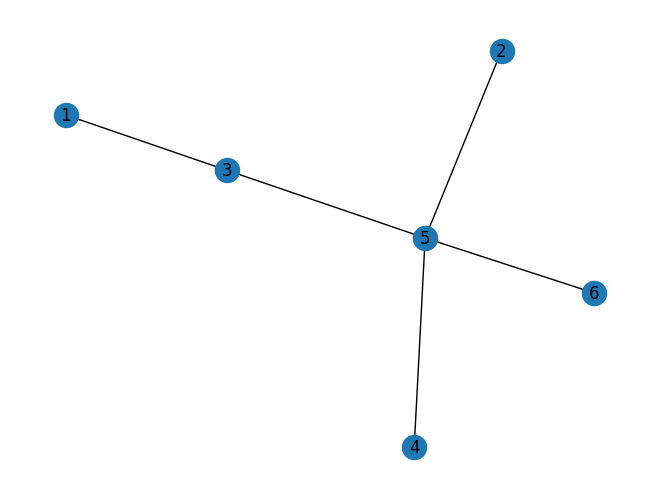

In [ ]:
tree = Graph.tree_from_Prufer("3 5 5 5")
print(tree)
tree.plot()

In [ ]:
print(tree.preorder(5))

5 2 3 1 4 6


In [ ]:
print(tree.postorder(5))

2 1 3 4 6 5


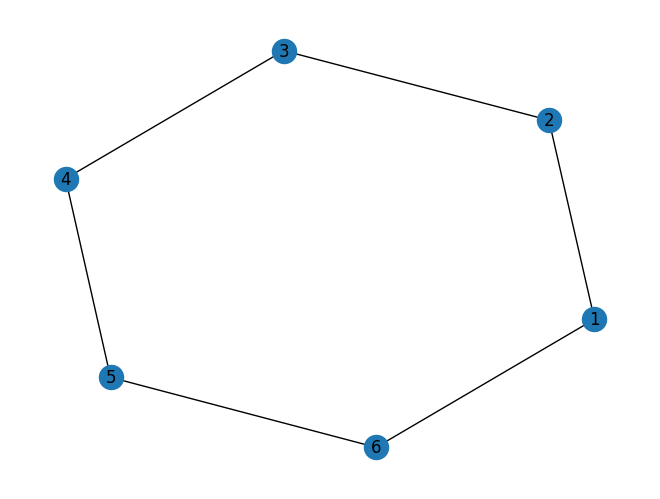

In [ ]:
graph1 = Graph.cycle(6)
graph1.plot()

In [ ]:
print(graph1.postorder(1))

6 5 4 3 2 1


In [ ]:
print(graph1.preorder(1))

RecursionError: maximum recursion depth exceeded

In [ ]:
graph = Graph.random_graph(15, 1/5)
print(graph.connected_components())
graphs = graph.ConnectedComponentsGraphs()
for g in graphs:
  print(g)

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15}, {12}]
1: 7 10
2: 6 8 15
3: 15
4: 5 6 7
5: 4
6: 2 4 14
7: 1 4 8
8: 2 7 10 11 13
9: 11 14
10: 1 8 11 15
11: 8 9 10 13 14
13: 8 11
14: 6 9 11
15: 2 3 10

12:



In [ ]:
V = {i for i in range(1, 11)}

In [ ]:
print(graph.InducedSubgraph(V))

1: 7 10
2: 6 8
3:
4: 5 6 7
5: 4
6: 2 4
7: 1 4 8
8: 2 7 10
9:
10: 1 8



### Distances in graph (an application of BFS)

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-06 14:11:00--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-06 14:11:00--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-11-06 14:11:01 (2.62 MB/s) - ‘weighted0.txt’ saved [114/114]



A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G



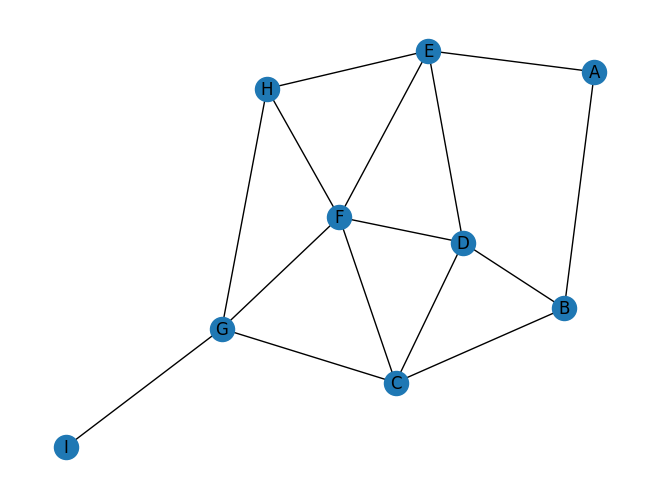

In [ ]:
graph1 = Graph.from_edges("weighted0.txt")
print(graph1)
graph1.plot()

In [ ]:
print(graph1.distance("A"))

{'A': 0, 'B': 1, 'E': 1, 'C': 2, 'D': 2, 'F': 2, 'H': 2, 'G': 3, 'I': 4}


#### Milgram's experiment &mdash; Small World Phenomenon

We will look whether $G(n, p)$ (eg. $G(4000, 1/600)$) is a good illustration.




In [ ]:
n = 200
p = 1/50

rgraph = Graph.random_graph(n, p)
graph = rgraph.ConnectedComponentsGraphs()[0]
print(len(graph.vertices()))

198


In [ ]:
md = {}
ecc = {}
for v in graph.vertices():
  dist = graph.distance(v)
  ecc[v] = max(dist.values())
  md[v] = sum(dist.values())/len(dist)
print("Radius:", min(ecc.values()), " Diameter: ", max(ecc.values()))
print("Average distance:", sum(md.values())/len(md))

Radius: 5  Diameter:  9
Average distance: 4.026221814100602


In [ ]:
dist, ndx = graph.FloydWarshall()

### Part 4 (Connected components via DFS)

In [ ]:
graph1 = Graph.random_graph(100, 1/25)
#print(graph1)

In [ ]:
print(len(graph1.connected_components()))
print(graph1.connected_components())

3
[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}, {69}]


### Part 3 (Prufer codes)

In [ ]:
%%writefile tree1.txt
1 3
3 5
2 5
4 5
6 5

Writing tree1.txt


In [ ]:
tree1 = Graph.from_edges("tree1.txt")

In [ ]:
print(tree1)

1: 3
3: 1 5
5: 3 2 4 6
2: 5
4: 5
6: 5



In [ ]:
print(tree1.Prufer())

3 5 5 5


In [ ]:
print(Graph.tree_from_Prufer("3 5 5 5"))

1: 3
2: 5
3: 1 5
4: 5
5: 2 3 4 6
6: 5



In [ ]:
print(Graph.tree_from_Prufer("5 4 3 1"))

1: 3 6
2: 5
3: 4 1
4: 5 3
5: 2 4
6: 1



In [ ]:
print(Graph.tree_from_Prufer("1 1 1 2 3"))

1: 4 5 6 2
2: 1 3
3: 2 7
4: 1
5: 1
6: 1
7: 3



### Part2

In [ ]:
%%writefile edges.txt
a b
b c
b d
d
d c
e
f


Writing edges.txt


In [ ]:
%cat edges.txt

a b
b c
b d
d
d c
e
f


In [ ]:
graph2 = Graph.from_edges("edges.txt")
print(graph2)

a: b
b: a c d
c: b d
d: b c
e:
f:



In [ ]:
graph2.to_neighbourlist("neighbourhood.txt")

In [ ]:
%cat "neighbourhood.txt"

a: b
b: a c d
c: b d
d: b c
e:
f:


In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-10-29 21:54:55--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-10-29 21:54:55--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-10-29 21:54:55 (8.61 MB/s) - ‘weighted0.txt’ saved [114/114]



In [ ]:
graph3 = Graph.from_edges("weighted0.txt")
print(graph3)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G



In [ ]:
# it works as well
!wget https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/weighted0.txt

--2025-10-29 21:55:18--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt.1’

weighted0.txt.1     100%[===================>]     114  --.-KB/s    in 0s      

2025-10-29 21:55:18 (4.35 MB/s) - ‘weighted0.txt.1’ saved [114/114]



In [ ]:
graph4 = Graph.random_graph(10, 1/3)
print(graph4)

1:
2: 8 9 10
3: 4 9
4: 3 7 8
5: 6
6: 5 7 10
7: 4 6 8 10
8: 2 4 7 9
9: 2 3 8
10: 2 6 7



In [ ]:
print(Graph.cycle(6))

1: 2 6
2: 1 3
3: 2 4
4: 3 5
5: 4 6
6: 5 1



### Part1

In [ ]:
vertices = ["a", "b", "c", "d"]
matrix = np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,0,1]])
print(vertices)
print(matrix)
print("---------------------------")
print_matrix(vertices, matrix)
print("---------------------------")
print_matrix(None,matrix)

['a', 'b', 'c', 'd']
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]]
---------------------------
a :  b
b :  a  c
c :  b  d
d :  d
---------------------------
1 :  2
2 :  1  3
3 :  2  4
4 :  4


In [ ]:
graph_dict = {
  "a": ["b"],
  "b": ["a", "c"],
  "c": ["b", "d"],
  "d": ["c"]
}
print(graph_dict)
print("---------------------------")
print_dict(graph_dict)

{'a': ['b'], 'b': ['a', 'c'], 'c': ['b', 'd'], 'd': ['c']}
---------------------------
a :  b
b :  a  c
c :  b  d
d :  c


In [ ]:
graph1 = Graph.from_matrix(matrix, vertices)
print(graph1)

a: b
b: a c
c: b d
d: d



In [ ]:
print(Graph(graph_dict))  # the same result

a: b
b: a c
c: b d
d: c



In [ ]:
print(graph1.vertices())

['a', 'b', 'c', 'd']


In [ ]:
print(graph1.matrix())

[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]]


In [ ]:
graph1.add_vertex("e")
print(graph1)

a: b
b: a c
c: b d
d: d
e:



In [ ]:
graph1.add_edge(["e", "f"])
print(graph1)

a: b
b: a c
c: b d
d: d
e: f
f: e



In [ ]:
graph1.add_arc(["e", "a"])  # breaking the symmetry
print(graph1)

a: b
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.add_edge(["e", "a"])  # restoring the symmetry
print(graph1)

a: b e
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.add_edge(["e", "f"]) # do nothing, an edge already exists
print(graph1)

a: b e
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.del_vertex("f")  # removing a vertex
print(graph1)

a: b e
b: a c
c: b d
d: d
e: a



In [ ]:
graph1.add_edge(["e", "e"]) # an error

ValueError: Loops are not allowed!

In [ ]:
graph1.add_arc(["e", "e"]) # OK - loops are allowed in digraphs
print(graph1)

a: b e
b: a c
c: b d
d: d
e: a e



In [ ]:
print(Graph.cycle(6))

1: 2 6
2: 1 3
3: 2 4
4: 3 5
5: 4 6
6: 5 1

